In [1]:
# set up
import pandas as pd
import numpy as np
import pickle
import time 
import os
import matplotlib.pyplot as plt
import datetime
from operator import itemgetter
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pylab import *
from matplotlib.font_manager import FontProperties  
data_folder_path = '../'
raw_data_path = "../raw_data"
storage_path = "../database_storage"
daily_path = "../daily"
DTBS_path = os.path.join(storage_path, "DTBS.pkl")
font = FontProperties(fname=r"simsun.ttf", size=14)  
matplotlib.rcParams['axes.unicode_minus'] =False
mpl.rcParams['font.sans-serif'] = ['SimHei']
tick_spacing = 4

# re-open
with open(DTBS_path, 'rb') as f:  
    DTBS = pickle.load(f)
    
def takeSecond(elem):
    return elem[1]


def retrieve_low_nodes(codes,dt,num):
    dl_rank = []
    for code in codes:
        if DTBS['A'][code][dt]['dl'] != 999:
            dl_rank.append((code, DTBS['A'][code][dt]['dl']))
    
    dl_rank.sort(key=takeSecond)
    low = dl_rank[0:num]
    return [i[0] for i in low]

def past_qs(days, code):
    
    for day in days:
            
        if DTBS['A'][code][day]['qs'] == 1:
            return 1
    
    return 0

def select_condition(codes, dt, fcd):
    satisfy = []
    if fcd[0] == 'lp':
        lm = calculate_time(dt, 'p', 20)
        
        for code in codes:
            if low_prc(code, dt, lm, fcd[1]):
                satisfy.append(code)
        
    else:
        for code in codes:
            if DTBS['A'][code][dt][fcd[0]] <= fcd[2] and DTBS['A'][code][dt][fcd[0]] >= fcd[1]:
                satisfy.append(code)
                    
    return satisfy

def rank(codes, dt, idx, num, d):
    rk = []
    if num == -1:
        num = len(codes)
    for code in codes:
        if idx == 'lp':
            if not np.isnan(DTBS['A'][code][dt]['dp']):
                lm = calculate_time(dt, 'p', 20)
                prc = get_prcs(code, lm)
                lp = absolute_low(prc, 0)
                rk.append((code, DTBS['A'][code][dt]['dp']/lp))
            
            
        elif idx != 'dl':
            if not np.isnan(DTBS['A'][code][dt][idx]):
                rk.append((code, DTBS['A'][code][dt][idx]))
        else:
            if not np.isnan(DTBS['A'][code][dt][idx]):
                if DTBS['A'][code][dt][idx] != 999:
                    rk.append((code, DTBS['A'][code][dt][idx]))
    if num >= len(rk):
        num = len(rk)
        
     
#     reverse = True 降序
    if d == 'd':
        rk.sort(key=takeSecond, reverse = True)
    else:
        rk.sort(key=takeSecond, reverse = False)

    if idx == 'lp':
        lp = [i for i in rk if i[1] == 1.0]
        ot = []
        if num - len(lp) > 0:
            ot = rk[len(lp):num]
        
        low = lp + ot
        
    else:    
        low = rk[0:num]
#     print("In",dt , len(low), "of", len(codes),  "is selected")   

#     print(low) 
    
    
    return [i[0] for i in low]
  

def get_prcs(code, dts):
    prc = []
    for dt in dts:
        prc.append(DTBS['A'][code][dt]['dp'])
    prc.sort()
    return prc
    
def relative_low(lst, pos):
    return np.quantile(a=lst, q = pos)
    
def absolute_low(lst, pos):
    return min(lst) + pos * (max(lst) - min(lst))

def low_prc(code, dt, lm, pos):
    prc = get_prcs(code, lm)
#     lp = min([relative_low(prc, pos), absolute_low(prc, pos)])
    lp = absolute_low(prc, pos)
    tp = DTBS['A'][code][dt]['dp']
#     if (tp <= lp):
#         print(code, tp, lp)
#     if tp <= lp:
#         print(tp, lp)
    return tp <= lp

def calculate_time(dt, d, l):
    time = []
    days = DTBS['D']['day']
    if d == 'p':
        for i in range(len(days)):
            if days[i] == dt:
                break
                
    return days[i-l+1:i+1]

------------------------------------
转股溢价率q0.00 31.26
转股溢价率q0.25 35.13
转股溢价率q0.50 36.92
转股溢价率q0.75 40.3
转股溢价率q1.00 50.91
------------------------------------
转股溢价率q0.1 33.56
转股溢价率q0.2 34.72
转股溢价率q0.3 35.46
转股溢价率q0.4 36.15
转股溢价率q0.6 38.26
转股溢价率q0.7 39.68
转股溢价率q0.8 41.21
转股溢价率q0.9 43.06
------------------------------------
到期收益率q0.00 -5.91
到期收益率q0.25 -3.6
到期收益率q0.50 -3.13
到期收益率q0.75 -2.67
到期收益率q1.00 -0.82
------------------------------------
到期收益率q0.1 -4.52
到期收益率q0.2 -3.82
到期收益率q0.3 -3.52
到期收益率q0.4 -3.29
到期收益率q0.6 -2.95
到期收益率q0.7 -2.79
到期收益率q0.8 -2.5
到期收益率q0.9 -2.05
最新2023-08-28共有 263 支平衡型转债, 今日均价 127.29 今日平均到期收益率 -4.56 今日平均转股溢价率 39.07


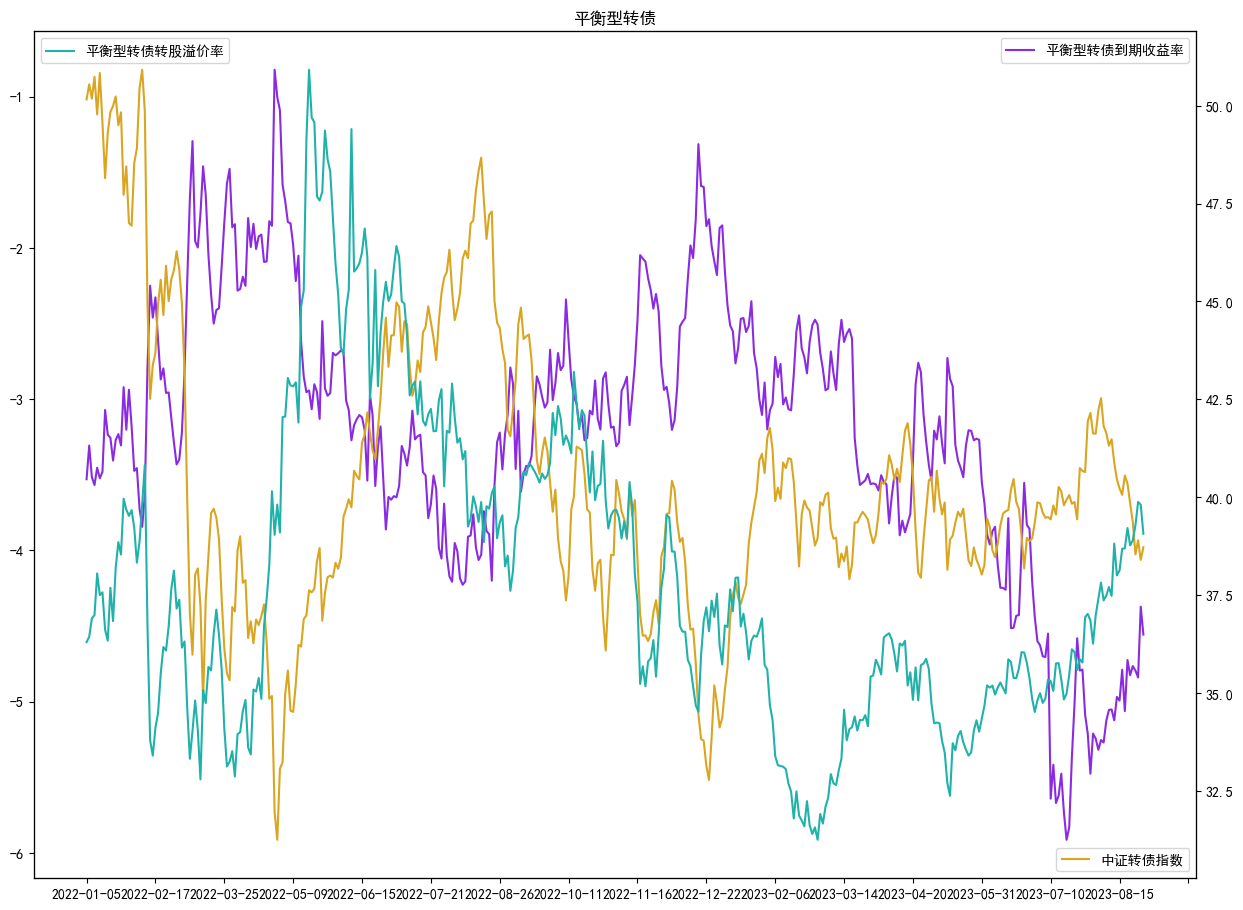

In [2]:
# PHX
plt.rcParams['figure.figsize'] = (15, 11) 

# 这里是更改回测时间周期，有个数据一周更新一次，所以需要每周一的时候手动更新一下这里的时间区间 
# By 张程功
dts = DTBS['D']['day'][1218:1618]

zz = []
for dt in dts:
    zz.append(DTBS['C']['zi'][dt])
tick_spacing = 26

all_mean1 = []

all_mean2 = []
all_mean3 = []
for dt in dts:
    c = []
    d = []
    e = []
    for code in DTBS['A'].keys():
        if DTBS['A'][code][dt]['ia'] == 1:
            if not DTBS['A'][code][dt].__contains__('pd'):
                print(code, dt)
            if DTBS['A'][code][dt]['pd'] >= -20 and  DTBS['A'][code][dt]['pd'] <= 20 :
                if not np.isnan(DTBS['A'][code][dt]['ytm']):
                    c.append(DTBS['A'][code][dt]['ytm'] )
                d.append(DTBS['A'][code][dt]['dp'] )    
                e.append(DTBS['A'][code][dt]['cpr'] )
    all_mean1.append(np.mean(c))
    all_mean2.append(np.mean(d))
    all_mean3.append(np.mean(e))
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(dts, all_mean1, c = 'blueviolet',linestyle='solid', label = '平衡型转债到期收益率')
ax1.legend(loc=1)

ax2 = ax1.twinx()
ax2.plot(dts, zz, c = 'goldenrod', linestyle='solid',label = '中证转债指数')
ax2.legend(loc=4)
ax2.get_yaxis().set_visible(False) 

ax3 = ax1.twinx()
ax3.plot(dts, all_mean3, c = 'lightseagreen',linestyle='solid', label = '平衡型转债转股溢价率')
ax3.legend(loc=2)

ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

plt.title('平衡型转债')
plt.savefig('平衡型转债', dpi=300)

all_mean3_clean = [i for i in all_mean3 if not np.isnan(i)]
print('------------------------------------')
print('转股溢价率q0.00', round(np.quantile(a=all_mean3_clean, q = 0),2))
print('转股溢价率q0.25', round(np.quantile(a=all_mean3_clean, q = 0.25),2))
print('转股溢价率q0.50', round(np.quantile(a=all_mean3_clean, q = 0.5),2))
print('转股溢价率q0.75', round(np.quantile(a=all_mean3_clean, q = 0.75),2))
print('转股溢价率q1.00', round(np.quantile(a=all_mean3_clean, q = 1),2))
print('------------------------------------')
print('转股溢价率q0.1', round(np.quantile(a=all_mean3_clean, q = 0.1),2))
print('转股溢价率q0.2', round(np.quantile(a=all_mean3_clean, q = 0.2),2))
print('转股溢价率q0.3', round(np.quantile(a=all_mean3_clean, q = 0.3),2))
print('转股溢价率q0.4', round(np.quantile(a=all_mean3_clean, q = 0.4),2))
print('转股溢价率q0.6', round(np.quantile(a=all_mean3_clean, q = 0.6),2))
print('转股溢价率q0.7', round(np.quantile(a=all_mean3_clean, q = 0.7),2))
print('转股溢价率q0.8', round(np.quantile(a=all_mean3_clean, q = 0.8),2))
print('转股溢价率q0.9', round(np.quantile(a=all_mean3_clean, q = 0.9),2))

all_mean1_clean = [i for i in all_mean1 if not np.isnan(i)]
print('------------------------------------')
print('到期收益率q0.00', round(np.quantile(a=all_mean1_clean, q = 0),2))
print('到期收益率q0.25', round(np.quantile(a=all_mean1_clean, q = 0.25),2))
print('到期收益率q0.50', round(np.quantile(a=all_mean1_clean, q = 0.5),2))
print('到期收益率q0.75', round(np.quantile(a=all_mean1_clean, q = 0.75),2))
print('到期收益率q1.00', round(np.quantile(a=all_mean1_clean, q = 1),2))
print('------------------------------------')
print('到期收益率q0.1', round(np.quantile(a=all_mean1_clean, q = 0.1),2))
print('到期收益率q0.2', round(np.quantile(a=all_mean1_clean, q = 0.2),2))
print('到期收益率q0.3', round(np.quantile(a=all_mean1_clean, q = 0.3),2))
print('到期收益率q0.4', round(np.quantile(a=all_mean1_clean, q = 0.4),2))
print('到期收益率q0.6', round(np.quantile(a=all_mean1_clean, q = 0.6),2))
print('到期收益率q0.7', round(np.quantile(a=all_mean1_clean, q = 0.7),2))
print('到期收益率q0.8', round(np.quantile(a=all_mean1_clean, q = 0.8),2))
print('到期收益率q0.9', round(np.quantile(a=all_mean1_clean, q = 0.9),2))

print('最新'+dts[-1]+'共有',len(d) ,'支平衡型转债, 今日均价',round(all_mean2[-1],2),'今日平均到期收益率',round(all_mean1[-1],2),'今日平均转股溢价率',round(all_mean3[-1],2))
        

        
plt.show()

In [5]:
print(DTBS['A']['127086.SZ']['2023-08-14']['csv']/DTBS['A']['127086.SZ']['2023-08-14']['cz']-1)
print(DTBS['A']['127086.SZ']['2023-08-14']['pd'])

0.10467780534863991
10.46778053486399


In [6]:
dt = '2023-07-17'
pinghenxingzhuanzhai = []
for code in DTBS['A'].keys():
        if DTBS['A'][code][dt]['ia'] == 1:
            if not DTBS['A'][code][dt].__contains__('pd'):
                print(code, dt)
            if DTBS['A'][code][dt]['pd'] >= -20 and  DTBS['A'][code][dt]['pd'] <= 20 :
                if not np.isnan(DTBS['A'][code][dt]['ytm']):
                    c.append(DTBS['A'][code][dt]['ytm'] )
                d.append(DTBS['A'][code][dt]['dp'] )    
                e.append(DTBS['A'][code][dt]['cpr'] )
                pinghenxingzhuanzhai.append(code)
print(pinghenxingzhuanzhai)

for code in DTBS['A'].keys():
    if code in pinghenxingzhuanzhai:
        print(code,DTBS['A'][code][dt]['cpr'],DTBS['A'][code][dt]['yl'],DTBS['A'][code][dt]['csv'],DTBS['A'][code][dt]['cz'],DTBS['A'][code][dt]['dp'],DTBS['A'][code][dt]['bl'],DTBS['B'][code]['cn'],DTBS['A'][code][dt]['ytm'])

['110088.SH', '127027.SZ', '110047.SH', '110063.SH', '110070.SH', '110092.SH', '111002.SH', '113058.SH', '113059.SH', '113566.SH', '113591.SH', '113600.SH', '113621.SH', '113640.SH', '113649.SH', '113657.SH', '118006.SH', '118018.SH', '118023.SH', '118029.SH', '123091.SZ', '123124.SZ', '123129.SZ', '123144.SZ', '123152.SZ', '123165.SZ', '123168.SZ', '123169.SZ', '127018.SZ', '127020.SZ', '127030.SZ', '127035.SZ', '127042.SZ', '127043.SZ', '127053.SZ', '127054.SZ', '127059.SZ', '127062.SZ', '127068.SZ', '127070.SZ', '127075.SZ', '128039.SZ', '128049.SZ', '128109.SZ', '128123.SZ', '128128.SZ', '128130.SZ', '128144.SZ', '110060.SH', '110074.SH', '110075.SH', '111000.SH', '113024.SH', '113030.SH', '113044.SH', '113505.SH', '113519.SH', '113526.SH', '113530.SH', '113546.SH', '113549.SH', '113597.SH', '113609.SH', '113637.SH', '113644.SH', '113651.SH', '113654.SH', '113656.SH', '113665.SH', '118014.SH', '118019.SH', '118025.SH', '123002.SZ', '123004.SZ', '123010.SZ', '123014.SZ', '123048.SZ'